# Precipitation Forecasting using VARMA

In this notebook, we investigate VARMA (Vector autoregressive moving average process) as a model to forecast precipitation.

## 0. Imports and Basic Setup

In [1]:
import os
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

## 1. Load Preprocessed Train, Validation, and Test Splits


In [2]:
train_data = pd.read_csv("../data/processed/train_data.csv")
validation_data = pd.read_csv("../data/processed/validation_data.csv")
test_data = pd.read_csv("../data/processed/test_data.csv")

# Sort splits by location -> YYYY -> DOY to ensure correct time ordering
train_data.sort_values(by=["location", "YYYY", "DOY"], inplace=True)
validation_data.sort_values(by=["location", "YYYY", "DOY"], inplace=True)
test_data.sort_values(by=["location", "YYYY", "DOY"], inplace=True)

## 2. Create Sequences for XGBoost


In [3]:
def create_sequences(df, feature_cols, target_col, seq_length=30):
    """
    Create sequences for time series prediction, grouped by location.
    Unlike RNNs which keep the temporal dimension, we flatten the sequences
    for XGBoost into a single feature vector.
    
    Parameters:
    df (pandas.DataFrame): DataFrame with time series data
    feature_cols (list): List of feature column names
    target_col (str): Name of the target column
    seq_length (int): Length of sequence to use for prediction
    
    Returns:
    tuple: (X array of shape (n_samples, seq_length * n_features),
            y array of shape (n_samples,))
    """
    X_list, y_list = {}, {}
    grouped = df.groupby("location", group_keys=True)
    
    for loc, loc_df in grouped:
        loc_df = loc_df.reset_index(drop=True)
        loc_features = loc_df[feature_cols].values
        loc_target = loc_df[target_col].values

        X_loc_list, y_loc_list = [], []

        for i in range(len(loc_df) - seq_length):
            # Flatten the sequence into a single feature vector
            sequence = loc_features[i:i + seq_length].flatten()
            X_loc_list.append(sequence)
            y_loc_list.append(loc_target[i + seq_length])

        X_list[loc] = np.array(X_loc_list)
        y_list[loc] = np.array(y_loc_list)
    
    return X_list, y_list


def create_sequences2(df, feature_cols, target_col, seq_length=30):
    """
    For each location independently, create sequences of length seq_length
    to predict the (seq_length+1)-th day's target_col.
    Returns:
        X: np.array of shape (num_samples, seq_length, num_features)
        y: np.array of shape (num_samples,)
    """
    X_list, y_list = [], []

    # Group by location so we don't mix data across different basins
    grouped = df.groupby("location", group_keys=True)

    for loc, loc_df in grouped:
        loc_df = loc_df.reset_index(drop=True)  # reindex after grouping

        # Convert to numpy for slicing
        loc_features = loc_df[feature_cols].values
        loc_target = loc_df[target_col].values

        # Slide over the time dimension for that location
        for i in range(len(loc_df) - seq_length):
            X_list.append(loc_features[i : i + seq_length])
            y_list.append(loc_target[i + seq_length])

    X_arr = np.array(X_list)
    y_arr = np.array(y_list)
    return X_arr, y_arr

## 3. Define Features and Target


In [4]:
exclude_cols = ["location", "YYYY", "DOY", "MM", "DD"]
feature_cols = [col for col in train_data.columns if col not in exclude_cols]
target_col = "prec"

print("Feature columns:", feature_cols)
print("Target column:", target_col)

Feature columns: ['2m_temp_max', '2m_temp_mean', '2m_temp_min', '2m_dp_temp_max', '2m_dp_temp_mean', '2m_dp_temp_min', '10m_wind_u', '10m_wind_v', 'fcst_alb', 'lai_high_veg', 'lai_low_veg', 'swe', 'surf_net_solar_rad_max', 'surf_net_solar_rad_mean', 'surf_net_therm_rad_max', 'surf_net_therm_rad_mean', 'surf_press', 'total_et', 'prec', 'volsw_123', 'volsw_4']
Target column: prec


## 4. Generate sequences

In [5]:
SEQ_LENGTH = 30
X_train, y_train = create_sequences2(train_data, feature_cols, target_col, seq_length=SEQ_LENGTH)
X_val, y_val = create_sequences2(validation_data, feature_cols, target_col, seq_length=SEQ_LENGTH)
X_test, y_test = create_sequences2(test_data, feature_cols, target_col, seq_length=SEQ_LENGTH)

print("Train sequence shape:", X_train.shape, y_train.shape)
print("Validation sequence shape:", X_val.shape, y_val.shape)
print("Test sequence shape:", X_test.shape, y_test.shape)

Train sequence shape: (1202300, 30, 21) (1202300,)
Validation sequence shape: (106600, 30, 21) (106600,)
Test sequence shape: (106500, 30, 21) (106500,)


In [6]:
X_unified = np.concatenate((X_train[:,:,18], X_val[:,:,18], X_test[:,:,18]))
y_unified = np.concatenate((y_train, y_val, y_test))

del X_train, X_val, X_test, y_train, y_val, y_test

In [32]:
print(X_train[4,:,:])
print(y_train[4])

[[-1.47741261 -1.29783418 -0.95791325 -1.37014381 -1.20358653 -0.99460269
   1.50261472 -0.9336199   0.92037887 -0.94578122 -0.38241545  0.10867588
  -1.45727337 -1.27462385 -0.35806043 -0.68452363 -0.09041648 -0.54822149
   2.47623844 -0.21203135  0.2729039 ]
 [-1.67482508 -1.40198681 -1.06576209 -1.420641   -1.22813297 -0.98301156
   0.29896779 -0.13192667  0.92037887 -0.94578122 -0.38241545  0.1369893
  -1.55011188 -1.34495103 -1.81098767 -1.26886075 -0.08945321 -0.98441828
   2.82046786 -0.21203135  0.2729039 ]
 [-1.86127019 -1.73758974 -1.55707347 -1.57213255 -1.63314915 -1.50461216
   0.49957561 -0.9336199   0.98723899 -0.94578122 -0.38241545  0.16559798
  -1.11686548 -1.13396948 -0.46982407 -1.0441157   0.05840988 -0.84667193
   1.74993238 -0.39347101  0.2729039 ]
 [-2.29996457 -2.09633769 -2.28804893 -2.17809878 -2.06271178 -2.22326188
  -0.03537858 -0.31008073  0.98723899 -0.94578122 -0.38241545  0.18269101
  -1.28191173 -1.17616579  0.20075773 -0.32493155  0.23228146 -0.99207

##  5. Build and Train VARMA Model


In [104]:
# arima = ARIMA(X_train[0,:,18], order=(5, 0, 1))

# for i in tqdm(range(X_unified.shape[0])):
#     arima = ARIMA(X_unified[i,:,18], order=(1, 0, 1))
#     model_fit = arima.fit()
# model_fit.summary()

(58975, 30, 21)

In [107]:
arima = ARIMA(X_unified[0,:,18], order=(5, 0, 1))
model_fit = arima.fit()

y_hat = model_fit.forecast()[0]
y_true = y_train[0]
y_n = (y_true, y_hat)
y_n

(-0.6001993664111122, 0.707976016289037)

In [12]:
import warnings
warnings.filterwarnings("ignore")
from multiprocessing import Process, Queue
from tqdm import tqdm


def train_model(part_id, X_part, y_part, result_queue):
    # print(f"Training model for part {part_id} with data shape {X_part.shape}...")
    # result = f"Result from part {part_id}"  # Replace with actual result
    # result_queue.put((part_id, result))  # Put result in the queue
    # print(f"Model for part {part_id} trained!")

    for i in range(X_part.shape[0]):
        arima = ARIMA(X_part[i], order=(1, 0, 1))
        model_fit = arima.fit()

        y_hat = model_fit.forecast()[0]
        y_true = y_part[i]
        y_n = (y_true, y_hat)
        result_queue.put(y_n)

        if i % 100 == 0:
            print(f"{part_id}: {i/X_part.shape[0]}")

    print(f"Model for part {part_id} trained!")


result_queue = Queue()
processes = []

num_parts = 24

X_parts = np.array_split(X_unified, num_parts)
y_parts = np.array_split(y_unified, num_parts)

for i in range(num_parts):
    p = Process(target=train_model, args=(i, X_parts[i][:100], y_parts[i][:100], result_queue))
    processes.append(p)
    p.start()

for p in processes:
    p.join()  # Wait for all processes to complete

print("Done training")

# Collect results
results = []
while not result_queue.empty():
    results.append(result_queue.get())

# Sort results by part_id (optional, if order matters)
# results.sort(key=lambda x: x[0])
#
# print("All models trained!")
# print("Results:", results)

0: 0.0
2: 0.03: 0.01: 0.0


4: 0.0
8: 0.0
9: 0.011: 0.05: 0.0


10: 0.07: 0.0

6: 0.0

12: 0.015: 0.013: 0.0
14: 0.0

17: 0.018: 0.0

16: 0.0
20: 0.0
22: 0.0
23: 0.0
21: 0.0
19: 0.0
Model for part 23 trained!
Model for part 2 trained!
Model for part 20 trained!
Model for part 3 trained!
Model for part 6 trained!
Model for part 17 trained!
Model for part 1 trained!
Model for part 18 trained!
Model for part 9 trained!
Model for part 0 trained!
Model for part 14 trained!
Model for part 13 trained!
Model for part 10 trained!
Model for part 15 trained!
Model for part 4 trained!
Model for part 5 trained!
Model for part 12 trained!
Model for part 16 trained!
Model for part 7 trained!
Model for part 21 trained!
Model for part 11 trained!
Model for part 8 trained!
Model for part 19 trained!
Model for part 22 trained!


Process Process-133:
Process Process-128:
Process Process-135:
Process Process-124:
Process Process-138:
Process Process-134:
Process Process-143:
Process Process-141:
Process Process-122:
Process Process-140:
Process Process-129:


KeyboardInterrupt: 

Process Process-121:
Process Process-127:
Process Process-130:
Process Process-136:
Process Process-123:
Process Process-139:
Process Process-125:
Process Process-132:
Process Process-144:
Process Process-142:
Process Process-137:
Process Process-131:
Process Process-126:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call

In [48]:
import warnings
warnings.filterwarnings("ignore")

from multiprocessing import Process, Manager

def train_model(part_id, X_part, y_part, results_dict):
    local_results = []  # Collect results locally to avoid synchronization issues
    for i in range(X_part.shape[0]):
        arima = ARIMA(X_part[i], order=(1, 0, 0))
        model_fit = arima.fit()

        y_hat = model_fit.forecast()[0]
        y_true = y_part[i]
        local_results.append([y_true, y_hat])

        if i % 100 == 0:
            print(f"Part {part_id}: {i}/{X_part.shape[0]}")

    # Store the results after computation
    results_dict[part_id] = local_results
    print(f"Model for part {part_id} trained!")

num_parts = 24
X_parts = np.array_split(X_unified, num_parts)
y_parts = np.array_split(y_unified, num_parts)

with Manager() as manager:
    results_dict = manager.dict()  # Shared dictionary for results
    processes = []

    for i in range(num_parts):
        p = Process(target=train_model, args=(i, X_parts[i], y_parts[i], results_dict))
        processes.append(p)
        p.start()

    for p in processes:
        p.join()

    print("Done training")
    # Convert results_dict to a standard dictionary
    results_100 = dict(results_dict)
    print(results)

Part 0: 0/58975
Part 1: 0/58975
Part 2: 0/58975
Part 3: 0/58975
Part 4: 0/58975
Part 5: 0/58975Part 6: 0/58975

Part 7: 0/58975
Part 8: 0/58975
Part 9: 0/58975
Part 10: 0/58975Part 11: 0/58975

Part 12: 0/58975
Part 13: 0/58975
Part 14: 0/58975
Part 15: 0/58975
Part 16: 0/58975
Part 17: 0/58975Part 18: 0/58975

Part 19: 0/58975
Part 20: 0/58975
Part 21: 0/58975
Part 22: 0/58975
Part 23: 0/58975
Part 4: 100/58975Part 2: 100/58975

Part 1: 100/58975
Part 0: 100/58975
Part 6: 100/58975
Part 3: 100/58975
Part 11: 100/58975
Part 5: 100/58975
Part 12: 100/58975
Part 10: 100/58975
Part 13: 100/58975
Part 9: 100/58975
Part 15: 100/58975
Part 7: 100/58975
Part 20: 100/58975
Part 18: 100/58975
Part 23: 100/58975
Part 14: 100/58975
Part 8: 100/58975
Part 16: 100/58975
Part 17: 100/58975
Part 22: 100/58975
Part 19: 100/58975
Part 21: 100/58975
Part 0: 200/58975
Part 4: 200/58975
Part 11: 200/58975Part 3: 200/58975

Part 6: 200/58975
Part 12: 200/58975
Part 2: 200/58975
Part 13: 200/58975
Part 1: 2

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [49]:
# (1, 0, 0), all
results_list = []
for _, value in results_100.items():
    results_list.extend(value)

results_list = np.array(results_list)
y_true = results_list[:,0]
y_hat = results_list[:,1]

mse = mean_squared_error(y_true, y_hat)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_hat)

print(f"\nTest MSE:  {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE:  {mae:.4f}")


Test MSE:  0.9706
Test RMSE: 0.9852
Test MAE:  0.6270


In [47]:
# (0, 0, 1), all
results_list = []
for _, value in results.items():
    results_list.extend(value)

results_list = np.array(results_list)
y_true = results_list[:,0]
y_hat = results_list[:,1]

mse = mean_squared_error(y_true, y_hat)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_hat)

print(f"\nTest MSE:  {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE:  {mae:.4f}")


Test MSE:  0.9640
Test RMSE: 0.9818
Test MAE:  0.6318


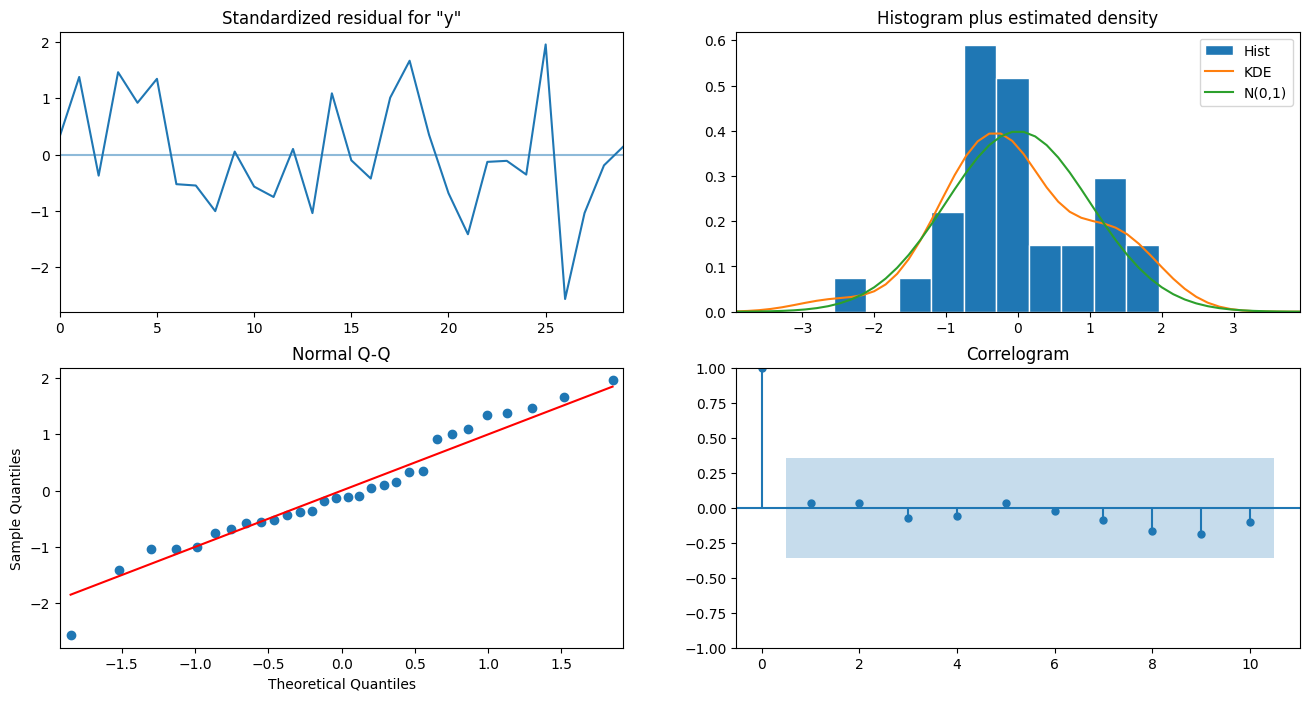

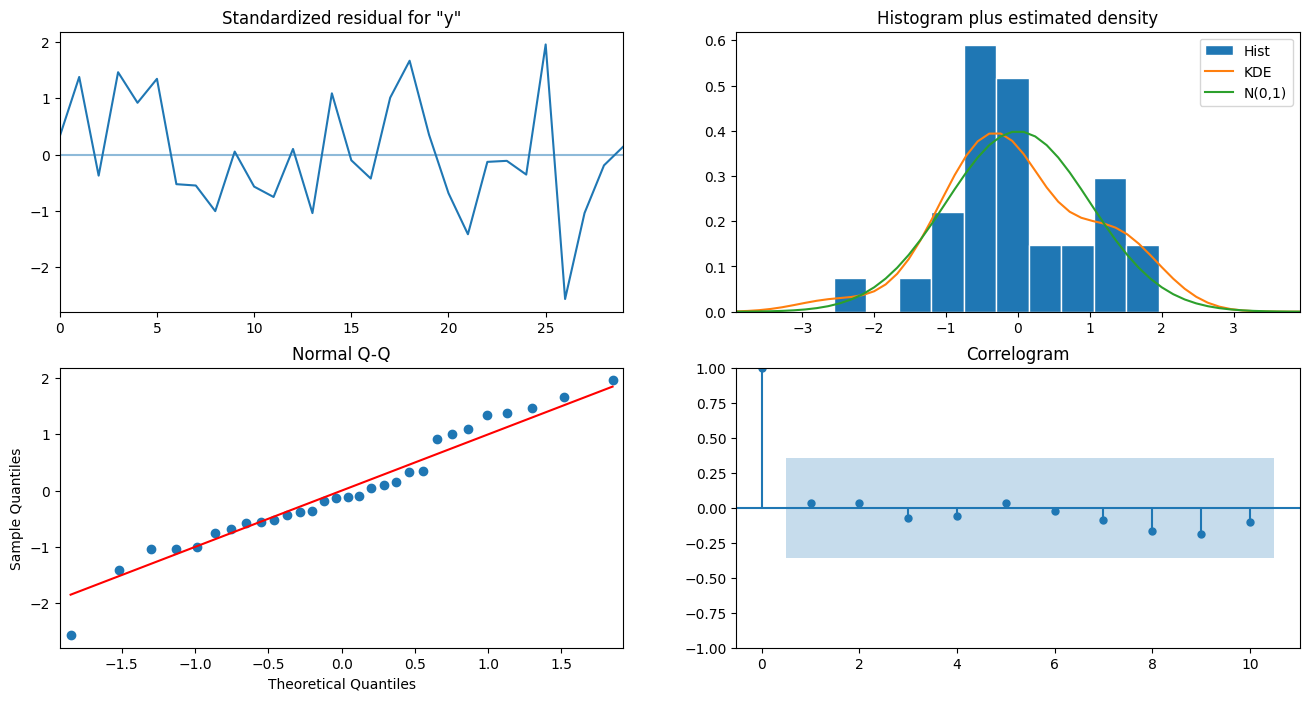

In [55]:
model_fit.plot_diagnostics(figsize=(16, 8))

In [65]:
y_hat = model_fit.forecast()
y_true = y_train[0]

print(y_hat)
print(y_true)
print(X_train[1,-1,18])

[0.70797602]
-0.6001993664111122
-0.6001993664111122


In [77]:
varma = VARMAX(X_train[0]+np.ones(X_train[0].shape)*6, order=(1,1))
model_fit = varma.fit()

/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/AMITECC/ex1/AMITECC_Ex1/.venv_a11/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/AMITECC/ex1/AMITECC_Ex1/.venv_a11/lib/python3.9/site-packages/statsmodels/tsa/statespace/varmax.py:395: UserWarning: Non-stationary starting moving-average parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting moving-average parameters'


LinAlgError: Matrix is not positive definite

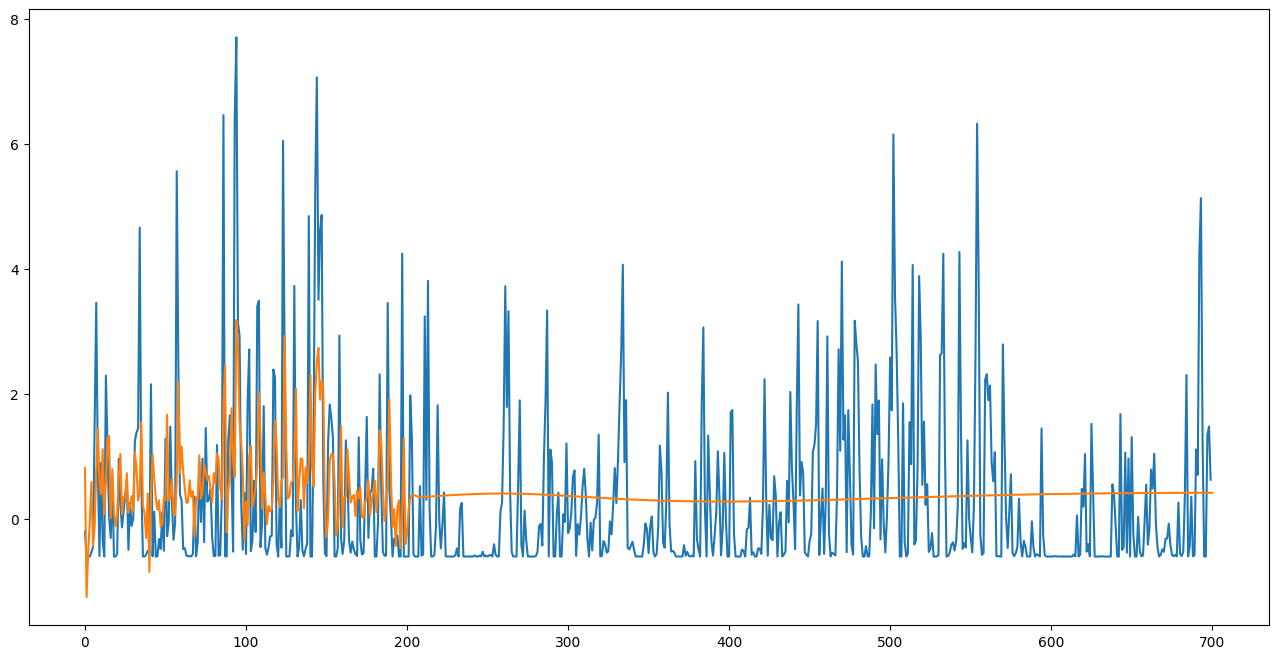

In [62]:
plt.rcParams['figure.figsize'] = (16, 8)
y_hat = arima.predict(800,1500)[:,18]
y_true = X_train["ID_102"][800:1500,18]

plt.plot(y_true)
plt.plot(y_hat)
plt.show()

In [92]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(X_train["ID_102"][:,18])
# Output the results
print('ADF Statistic: %f' % adf_test[0])
# Value below 0.05 indicates stationarity
print('p-value: %f' % adf_test[1])

ADF Statistic: -23.958779
p-value: 0.000000


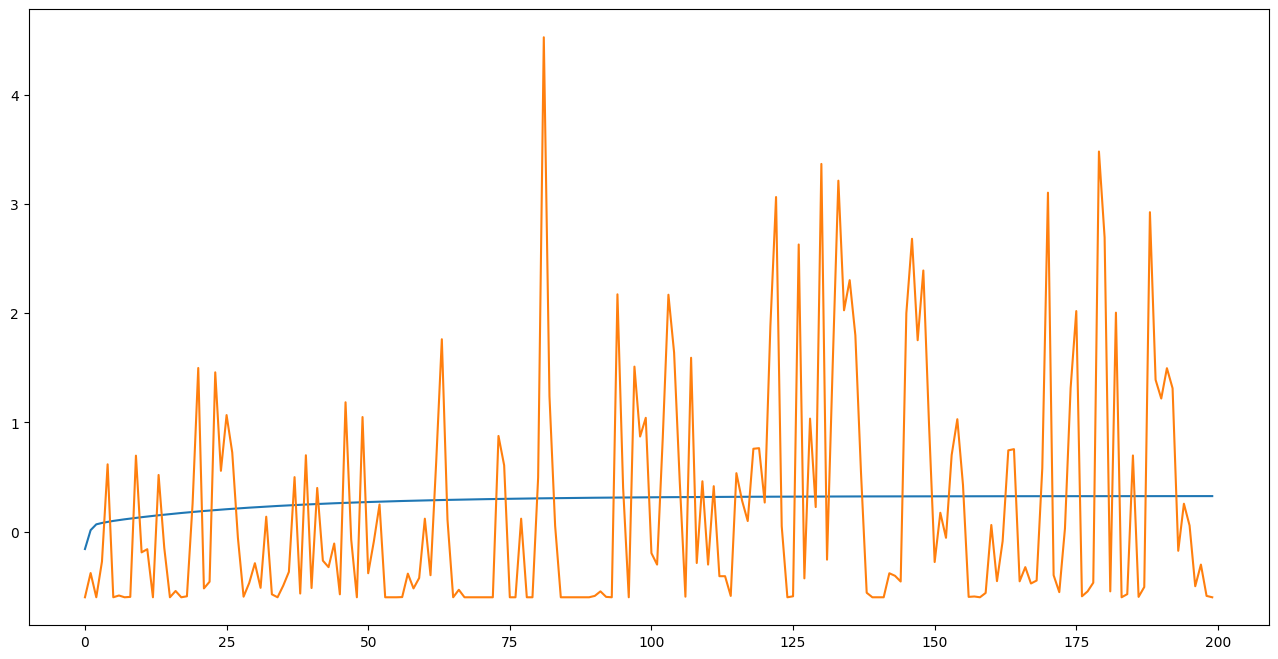

In [99]:
from statsmodels.tsa.arima.model import ARIMA


arima = ARIMA(X_train["ID_102"][:,18], order=(5, 0, 1))
arima = arima.fit()
y_hat = arima.get_forecast(steps=200).predicted_mean

# y_hat = model_fit.predict(start=1001, end=1100)[:,18]
y_true = X_val["ID_102"][:200,18]

plt.plot(y_hat)
plt.plot(y_true)
plt.show()

## 6. Evaluate the Model

In [7]:
# Make predictions
val_preds = model.predict(dval)
test_preds = model.predict(dtest)

# Calculate metrics for validation set
val_mse = mean_squared_error(y_val, val_preds)
val_rmse = np.sqrt(val_mse)
val_mae = mean_absolute_error(y_val, val_preds)

print(f"Validation MSE:  {val_mse:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Validation MAE:  {val_mae:.4f}")

# Calculate metrics for test set
test_mse = mean_squared_error(y_test, test_preds)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, test_preds)

print(f"\nTest MSE:  {test_mse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE:  {test_mae:.4f}")

Validation MSE:  0.8516
Validation RMSE: 0.9228
Validation MAE:  0.5886

Test MSE:  0.8386
Test RMSE: 0.9158
Test MAE:  0.5942


## 7. Visualize Predictions

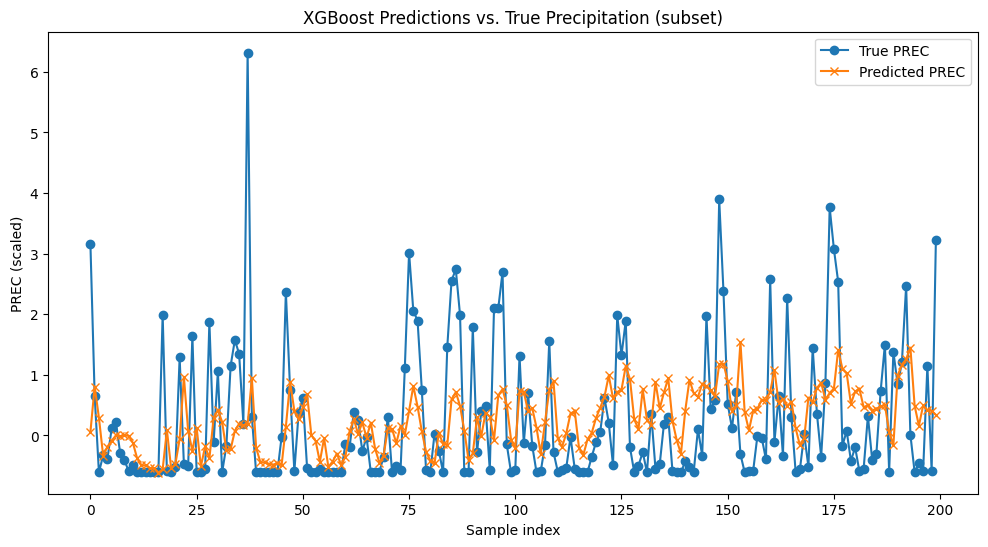

In [8]:
num_samples_to_plot = 200
plt.figure(figsize=(12,6))
plt.plot(y_test[:num_samples_to_plot], label='True PREC', marker='o')
plt.plot(test_preds[:num_samples_to_plot], label='Predicted PREC', marker='x')
plt.title("XGBoost Predictions vs. True Precipitation (subset)")
plt.xlabel("Sample index")
plt.ylabel("PREC (scaled)")
plt.legend()
plt.show()

## 8. Feature Importance Study


To investigate feature importance in XGBoost models, we measure the gain of certain variables. The gain in XGBoost measures the average improvement in the loss function (e.g., RMSE) achieved by splits using a specific feature across all trees. A higher gain indicates that the feature contributes more significantly to reducing prediction error.  

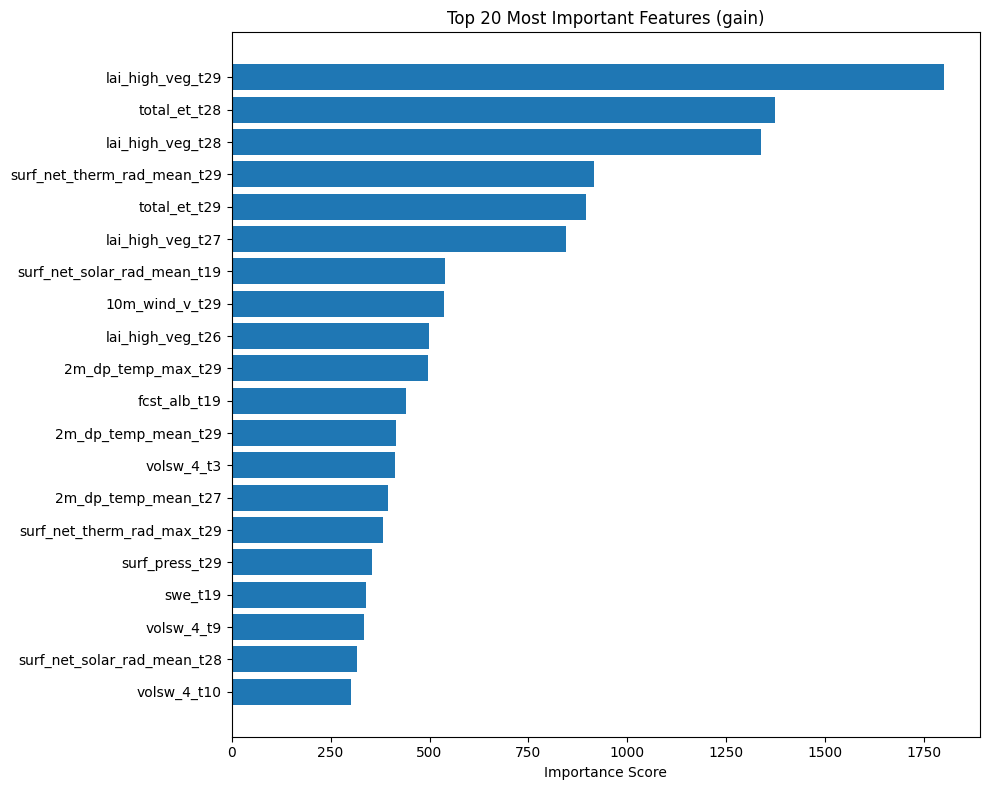

In [9]:
# Get feature importance scores
importance_scores = model.get_score(importance_type='gain')
importance_df = pd.DataFrame(
    [(k, v) for k, v in importance_scores.items()],
    columns=['Feature', 'Importance']
).sort_values('Importance', ascending=True)

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'].tail(20), importance_df['Importance'].tail(20))
plt.title('Top 20 Most Important Features (gain)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()


## 9. Analyze Temporal Importance


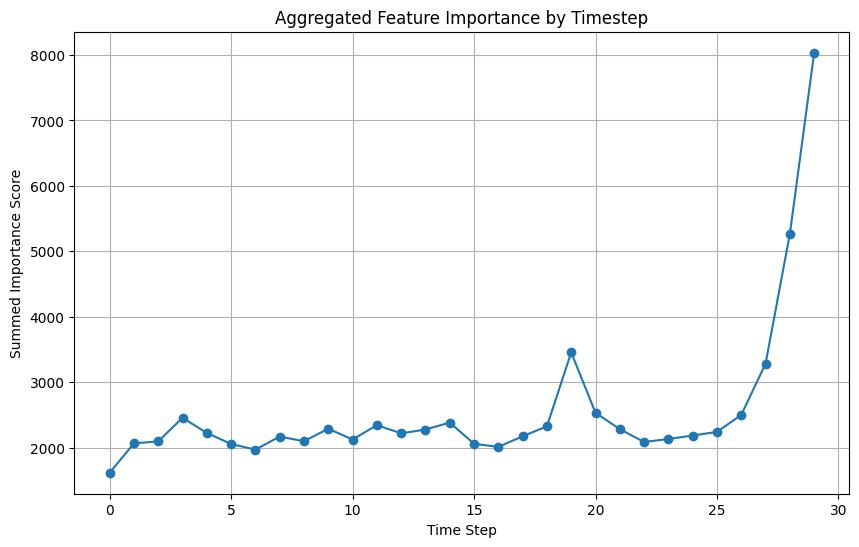

In [10]:
# Extract timesteps from feature names and aggregate importance by time
def extract_timestep(feature_name):
    return int(feature_name.split('_t')[-1])

importance_df['timestep'] = importance_df['Feature'].apply(extract_timestep)
temporal_importance = importance_df.groupby('timestep')['Importance'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(temporal_importance['timestep'], temporal_importance['Importance'], marker='o')
plt.title('Aggregated Feature Importance by Timestep')
plt.xlabel('Time Step')
plt.ylabel('Summed Importance Score')
plt.grid(True)
plt.show()

Here, we can see that, as one would expect, the later time steps are much more important than the earlier ones